# **GR5242 HW02 Problem 2: Transfer learning with MobileNets**


**Instructions**: This problem is an individual assignment -- you are to complete this problem on your own, without conferring with your classmates.  You should submit a completed and published notebook to Courseworks; no other files will be accepted.

**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

## Description:
In this homework, you will practice (1) going over the full procedure of training a neural network and (2) extending your knowledge on TF2, by implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and to classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, please refer to the official documentations for more info in necessary: [Keras](https://keras.io/), [TF Datasets](https://www.tensorflow.org/datasets), and [TF Hub](https://www.tensorflow.org/hub).



**Import modules for later usage.**

In [23]:
import tensorflow as tf

#from tensorflow import keras 
!pip install -q tensorflow tensorflow-datasets matplotlib tensorflow_hub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.8.0
Keras version: 2.8.0


## **Question 1: Download and format the data**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (a) Data Pre-processing

First, load the dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview) and split the data into training and testing sets. How many training and testing samples do you have?

In [24]:
(train_data, test_data) = tfds.load('oxford_flowers102',split=(tfds.Split.TRAIN, tfds.Split.TEST),as_supervised=True)

In [25]:
print((list(train_data.take(1)))) # this part is useful but not necessary

[(<tf.Tensor: shape=(500, 667, 3), dtype=uint8, numpy=
array([[[1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 2, 0],
        [1, 2, 0],
        [1, 2, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 7, 2],
        [6, 7, 2],
        [5, 6, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 7, 2],
        [6, 7, 2],
        [5, 6, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 7, 2],
        [6, 7, 2],
        [5, 6, 1]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=72>)]


In [26]:
# Print the number of training and testing samples

print(len(list(train_data)))
print(len(list(test_data)))

1020
6149


Next, we would like to format all the images for the MobileNet module. 

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [27]:
# Initiate the parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [28]:
# Define a function to format the data according to the previous description
@tf.function
def format_example(image, label):
    print("Format example called!")
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Apply the above function to the previous train_data and test_data, to get the formatted training and testing sets.   
train = train_data.map(format_example)
test = test_data.map(format_example)

Format example called!


### (b) Data Exploration

Let's plot some of the data.

In [29]:
assert isinstance(train, tf.data.Dataset)
assert isinstance(test, tf.data.Dataset)
print(train)
print(test)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


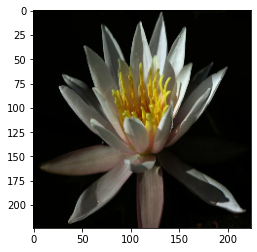

Label: 72


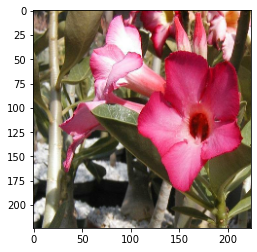

Label: 84


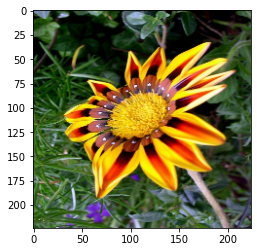

Label: 70


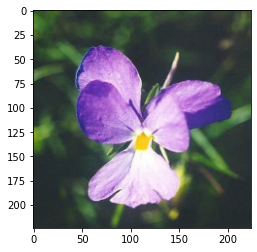

Label: 51


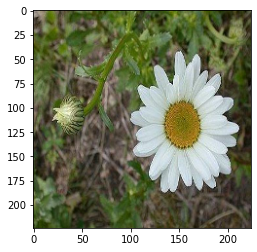

Label: 48


In [30]:
for example in train.take(5):  # Take first 5 examples
  image, label = example[0], example[1]
  plt.imshow(image.numpy())
  plt.pause(0.5);
  print("Label: %d" % label.numpy())

In the data exploration stage, what is the purpose of "***assert isinstance(train, tf.data.Dataset)***"?

**Answer:**

It is used in unit testing to check whether an object is an instance of a given class or not. If the object is an instance of the given class it will return true else it returns false.

## **Question 2: Self-defined CNN** 

In this section, you will define your own CNN (convolutional neural network) to classify the Oxford flowers. 

Recall that to build a neural network using tf.keras, there are three steps: defining the model, compiling the model and fitting the model. Each step should be straightforward. For further info about how to use tf.keras layers, please go to the [official documentation](https://keras.io/layers/core/).

After fitting the model, visualize your model in TensorBoard.

In this stage, we do not ask for a good performance. But please ensure that you obtain a trainable model with no programming bugs. To show this, print the training progress bar. 

In [31]:
# Step a: Model definition
# Use a Keras Sequential model for defining your own CNN
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Flatten
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(102, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 173056)           

In [32]:
# Step b: Model compilation
# Be sure to specify the optimizer, loss and metric as required
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [33]:
# Step c: Model fitting
# Use the prepared training data to fit your CNN
model.fit(train.shuffle(100).batch(32).prefetch(1),
                    epochs=5,
                    validation_data=test.shuffle(100).batch(32).prefetch(1))

Epoch 1/5
32/32 [==============================] - 67s 2s/step - loss: 5.4120 - accuracy: 0.0059 - val_loss: 4.3573 - val_accuracy: 0.0093
Epoch 2/5
32/32 [==============================] - 74s 2s/step - loss: 3.8786 - accuracy: 0.1206 - val_loss: 4.0616 - val_accuracy: 0.0849
Epoch 3/5
32/32 [==============================] - 71s 2s/step - loss: 2.1162 - accuracy: 0.5196 - val_loss: 4.5311 - val_accuracy: 0.1207
Epoch 4/5
32/32 [==============================] - 65s 2s/step - loss: 0.5704 - accuracy: 0.8882 - val_loss: 6.6073 - val_accuracy: 0.1049
Epoch 5/5
32/32 [==============================] - 65s 2s/step - loss: 0.1121 - accuracy: 0.9755 - val_loss: 7.2416 - val_accuracy: 0.1174


### **Reflection Questions:**

(d) How did you choose your network structure? \\
(e) Which optimizer did you use? Why? \\

**Answer:** \\

(d) I build a CNN model to process inputs of shape (224, 224, 3) using Conv2D and and MaxPooling2D layer. The width and height dimensions tend to shrink as you go deeper in the network to add more output channels in each Conv2D layer. Thus, we have 3 Conv2D layers and use Flatten and Dense layer to perform classification. Finally, we use a Dense layer with 102 outputs with softmax activation to include all 102 classes and finish our network structure.

(e) I use the Adam optimizer. Since the algorithm is straightforward to implement, has faster running time, low memory requirements, and requires less tuning than any other optimization algorithm. Thus, the results are generally better than other optimizers.


## **Question 3: Transfer Learning Using Pre-trained Model**

There are several types of transfer learning, as illustrated [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, you will practice B2, using MobileNet_V2.

### Freeze the pre-trained model and fine-tune the transfer learning.

In [34]:
MobileNet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

Now you can go through the same steps to build and train the transfer learning model.

In [35]:
# Step a: Model definition
# Use a Keras Sequential model for defining the transfer learning model (B1 style)
MobileNet.trainable=False

model_transfer = tf.keras.Sequential([
                            MobileNet, 
                            Flatten(input_shape=(224,224,3)),
                            Dense(1024, activation='relu'),
                            Dense(102, activation='relu'),
        ])

In [36]:
# visualize the model graphical structure
model_transfer.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              64226304  
                                                                 
 dense_5 (Dense)             (None, 102)               104550    
                                                                 
Total params: 66,588,838
Trainable params: 64,330,854
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
# This block is for Tensorboard, which will help you visualize

# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime, os
from packaging import version

# Clear any logs from previous runs
!rm -rf ./logs/ 

# For use of Tensorboard later
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [38]:
# Step b: Model compilation
# Be sure to specify the optimizer, loss and metric as required
model_transfer.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [39]:
# Step c: Model fitting
# Use the prepared training data to fit the transfer learning model for 5 epochs

model_transfer.fit(train.shuffle(100).batch(32).prefetch(1),
                    epochs=5,
                    validation_data=test.shuffle(100).batch(32).prefetch(1),
          verbose=2, # include this verbosity
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, histogram_freq=1)]) # include this callback

Epoch 1/5
32/32 - 198s - loss: 16.8747 - accuracy: 0.0225 - val_loss: 16.9517 - val_accuracy: 0.0159 - 198s/epoch - 6s/step
Epoch 2/5
32/32 - 191s - loss: 16.9372 - accuracy: 0.0216 - val_loss: 16.9517 - val_accuracy: 0.0153 - 191s/epoch - 6s/step
Epoch 3/5
32/32 - 197s - loss: 16.9372 - accuracy: 0.0216 - val_loss: 16.9517 - val_accuracy: 0.0151 - 197s/epoch - 6s/step
Epoch 4/5
32/32 - 199s - loss: 16.9372 - accuracy: 0.0216 - val_loss: 16.9517 - val_accuracy: 0.0151 - 199s/epoch - 6s/step
Epoch 5/5
32/32 - 198s - loss: 16.9372 - accuracy: 0.0216 - val_loss: 16.9517 - val_accuracy: 0.0151 - 198s/epoch - 6s/step


In [41]:
# Step d: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

initial_epochs = 10
loss0, accuracy0 = model_transfer.evaluate(test.shuffle(100).batch(32).prefetch(1))
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

193/193 [==============================] - 86s 441ms/step - loss: 16.9517 - accuracy: 0.0151
initial loss: 16.95
initial accuracy: 0.02


### Look at the network architecture and performance evolution in tensorboard. 

In [42]:
# Refresh TensorBoard

%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 21964), started 11:58:21 ago. (Use '!kill 21964' to kill it.)

(e) Fine-tune some parameters in your network to see if you can improve the performance on testing data.

In [43]:
########## Your code here ##########
MobileNet.trainable = True

print("Number of layers in the base model: ", len(MobileNet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in MobileNet.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [44]:
model_transfer.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [45]:
model_transfer.fit(train.shuffle(100).batch(32).prefetch(1),
                         epochs=10,
                         initial_epoch=5,
                         validation_data=test.shuffle(100).batch(32).prefetch(1))

Epoch 6/10
32/32 [==============================] - 119s 4s/step - loss: 16.9374 - accuracy: 0.0167 - val_loss: 16.9517 - val_accuracy: 0.0154
Epoch 7/10
32/32 [==============================] - 117s 4s/step - loss: 16.9374 - accuracy: 0.0167 - val_loss: 16.9517 - val_accuracy: 0.0158
Epoch 8/10
32/32 [==============================] - 110s 4s/step - loss: 16.9374 - accuracy: 0.0147 - val_loss: 16.9517 - val_accuracy: 0.0159
Epoch 9/10
32/32 [==============================] - 115s 4s/step - loss: 16.9374 - accuracy: 0.0157 - val_loss: 16.9517 - val_accuracy: 0.0161
Epoch 10/10
32/32 [==============================] - 118s 4s/step - loss: 16.9374 - accuracy: 0.0186 - val_loss: 16.9517 - val_accuracy: 0.0161


### **Reflection Questions:**

(f) Briefly explain the network structure of MobileNet and how is it different from other models? \\
(g) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why? \\
(h) What are some pros and cons of doing transfer learning? \\
(i) What is a batch? How does the batch size affect the training process? \\
(j) What is an epoch during the training process?

**Answers:** \\

(f) The MobileNet model is designed to be used in mobile applications. It uses depthwise separable convolutions. It significantly reduces the number of parameters when compared to the network with regular convolutions with the same depth in the nets. This results in lightweight deep neural networks.

(g) In my experiment, the learning rate is very sensitive to the network since it determines how quickly a network updates its parameters. Low learning rate slows down the learning process but converges smoothly. Larger learning rate speeds up the learning but may not converge. 

(h) Pros: Transfer learning can save lots of training time. You do not need a lot of data to train your network from the beginning. Neural network works better in most cases. <br>
Cons: Transfer learning may have a very limited effect when we switch the data content from one type to another. Hence, transfer learning maybe no better than training from scratch, as the networks learn very different high-level features in the two tasks.

(i) Batch refers to how training samples are used while computing the loss function. The number of examples from the training dataset used in the estimate of the error gradient is called the batch size. Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error. Larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model exemplified by lower variance in classification accuracy.

(j) An epoch indicates the number of passes of the entire training dataset the machine learning algorithm has completed. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.